In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


print()
print(np.__version__)
print(pd.__version__)
print(tf.__version__)


1.19.2
1.1.0
2.4.1


# Get Dataset

In [2]:
from src.phac import PHAC

can = PHAC()

In [20]:
ma_win=30

# Clean and extract test data
tests = can.var_by_location("new_tests_rate", *can.provinces, ma_window=1)
valid_test_idx = (tests[location] > 0)
tests_valid = tests[valid_test_idx]

tests_ave = can.var_by_location("new_tests_rate", *can.provinces, ma_window=ma_win)

print("Tests:", tests.shape, tests_valid.shape)

# Clean and extract case data
cases = can.var_by_location("new_cases_rate", *can.provinces, ma_window=1).fillna(0)
cases_valid = cases[valid_test_idx]

cases_ave = can.var_by_location("new_cases_rate", *can.provinces, ma_window=ma_win)

print("Cases:", cases.shape, cases_valid.shape)
print(len(cases_valid[(cases_valid.isnull()).any(axis=1)]))


Tests: (460, 14) (442, 14)
Cases: (460, 14) (442, 14)
0


# Finding Incident Rate from Observed Case Rate

Case counts for COVID-19 at a given time $t$ reflect the true incidence rate $p$ and the probability that an indivdual with COVID-19 will present for a test.  Precisely, let $I_t$ be the (bernouli) random variable representing the true incidence at $t$, and let $T_t$ be the bernouli random variable that represents the test rate at $t$.  Also let $C_t$ be the random variable modelling the observed case count at $t$.  Then

(1) $\frac{P(C)}{P(T)} = P(I | T)$; i.e., $P(C) = P(I|T) P(T)$

So, applying Bayes theorum, we have

(2) $P(I) = \frac{P(C)}{P(T|I)}$; i.e., $P(C) = P(I) P(T|I)$

that is, the true incidence is the observed incidence divided by the probability that an infected individual will present for testing.

## Looking at Case and Test Data

For the location defined in the previous cell, the graphs below show 
* timeseries of the daily test rate (tests per 100,000 population),
* timeseries of the daily (observed) case rate (cases per 100,000 population),
* timeseries of the daily positive test rate,
* a plot of the case rate vs test rate, and finally
* a plot of the case rate vs test rate for all locations

Consider the results for Ontario.  

First we see that in Ontario, the test rate had a steady increase until it reached about 350 daily tests per 100,000 population. There is significant variation around the moving average.  If you zoom in on the data, one sees that there is a weekly cycle with fewer tests reported on the weekend.  

Cases are a function of the number of tests conducted.  Looking at the positive test rate, we see three clear peaks. This is reflected in the case data as well but there is a upward trend line that is driven by the upward trend in the test rate.

Looking at cases vs tests.   For Ontario, cases are almost constant until the test rate reaches about 150 tests per 100,000 population.  After this we see an explosion with, what appears to be, a linear trend.  From (2) this suggests that once the test rate reaches a certain threshold, the test sampling becomes unbiased, $P(T|I) = P(T)$, and $P(I) = P(C) / P(T)$.  When the test rate is small, $P(I|T) > P(I)$ because tests are reserved (either by policy or self-selection) to individuals who have indications of illness.  What we see from the Ontario data is that $P(I|T)$ decrease almost linearly until it reaches $P(I)$.  (Note, $P(I|T)$ would be less than $P(I)$ in the presence of a strategy to test individuals without symptoms and not test those whose symptoms indicate treatment. Near the start of the pandemmic when tests were in short supply and symptomatic individuals were discouraged from being tested unless presenting with severe symptoms.)

Thus, if we restrict our dataset to points at which $P(T) > \tau$, we can estimate the true incidence as $P(C) / P(T)$.  The challenge is finding $\tau$


In [21]:
location = "Ontario"

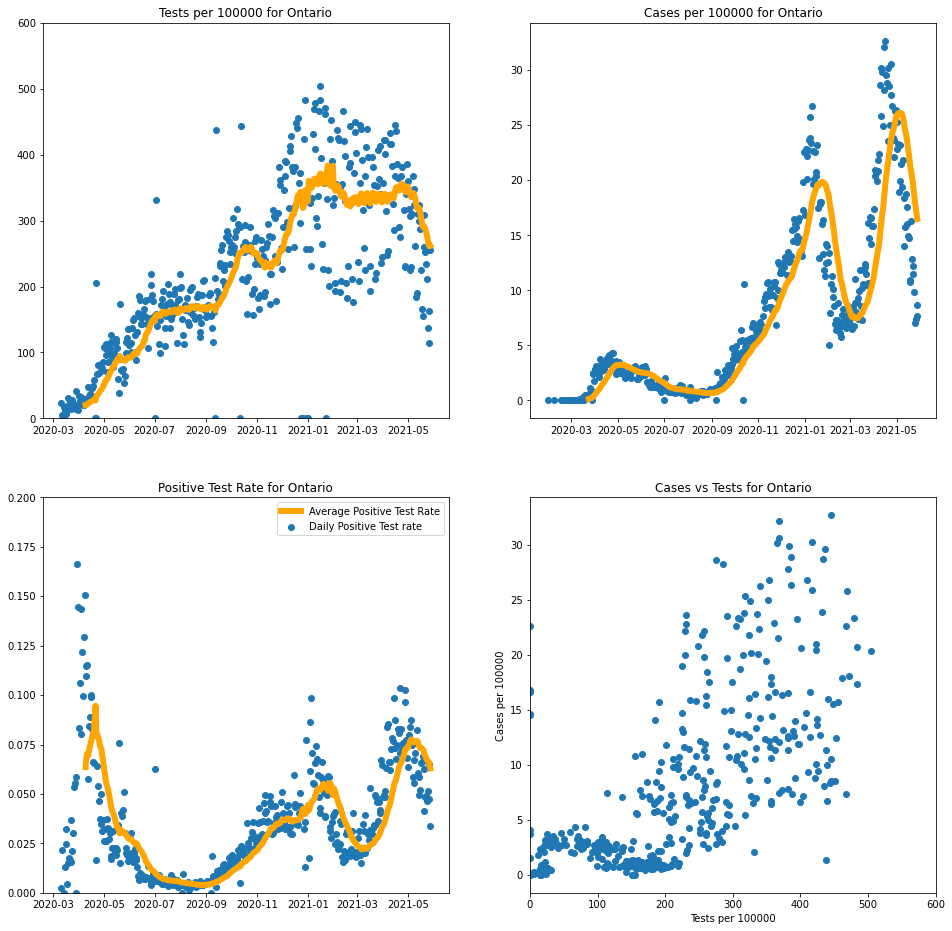

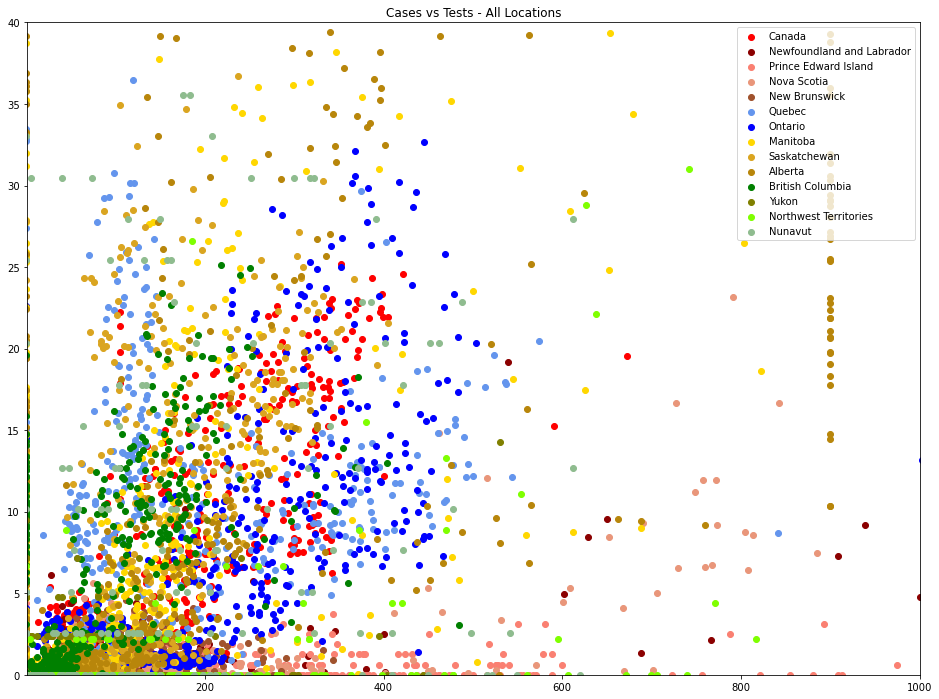

In [24]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(16,16))

scale = 100000

# Plot Tests
ax[0,0].scatter(tests.index, scale * tests[location])
ax[0,0].plot(tests_ave.index, scale * tests_ave[location], lw=6, c="orange")
ax[0,0].set_ylim((0,600))
ax[0,0].set_title(f"Tests per {scale} for {location}")

# Plot Cases
ax[0,1].scatter(cases.index, scale * cases[location])
ax[0,1].plot(cases.index, scale * cases_ave[location], lw=6, c="orange")
ax[0,1].set_title(f"Cases per {scale} for {location}")

# Plot positive test rate (P(C) / P(T))
ax[1,0].scatter(tests_valid.index, cases_valid[location] / tests_valid[location], 
                label="Daily Positive Test rate")
ax[1,0].plot(tests_ave.index, cases_ave[location] / tests_ave[location], 
             lw=6, c="orange", label="Average Positive Test Rate")
ax[1,0].set_ylim((0,0.2))
ax[1,0].set_title(f"Positive Test Rate for {location}")
ax[1,0].legend()

# Plot Cases vs Tests
ax[1,1].scatter(scale * tests_valid[location], scale * cases_valid[location])
ax[1,1].set_xlim(0,600)
ax[1,1].set_ylabel(f"Cases per {scale}")
ax[1,1].set_xlabel(f"Tests per {scale}")
ax[1,1].set_title(f"Cases vs Tests for {location}")

fig1, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(16,12))
for loc in can.provinces:
    ax1.scatter(scale * tests_valid[loc], scale * cases_valid[loc], c=can.prov_colours[loc], label=loc)
ax1.set_xlim((1,1000))
ax1.set_ylim((0,40))
ax1.set_title("Cases vs Tests - All Locations")
ax1.legend(loc="upper right")

## Analyse Cases by Test Rate

In these next few cells we explore firther the functional relationship between the test rate and the case rate.  

We create a DataFrame with two columns test_rate_interval and case_rate.  The feature test_rate_interval is defined as `10 * (int((scale/10) * test_rate) + 1)`.  In words, we split the unit interval into `scale/10` subintervals and label the test_rate_interval with the right edge scaled by `scale`.  We also remove 
all data points for which test_rate is undefined or zero.  Location data is ignored.

From this data frame we derive a new dataframe, `case_stats_by_test_freq` that provides the count, mean, var, min, and max for each interval defined above, eliminating rows where `count < 10`

When we look at data from all provinces, we see a roughly linear relationship between test rate and the mean case rate as expected.  Because of the presence of provinces with low case counts, minimum case rates are zero. Except at the far right, the max case rate seems to be constant within a wide band (20 per 100,000) around 40.  The graph of variance against test rate is largely linear, although there is a bifurcation for larger test rates that warrents more investigation.

If we restrict ourselves to Ontario data only, the mean cae rate and its variance is largely small and constant until the test rate hits about 150 per 100,00.  After this point, it behaves as the collective data.  During the early phases of the pandemic, Ontario had a strict policy of testing only when test results would change the treatement or public health response.  This may explain this behaviour.  Combining jurisdictions smooths out the effect of this test strategy

In [174]:
# Set locations to a list of provinces.  Only data from these provinces will be used
locations = can.provinces

(0.0, 600.0)

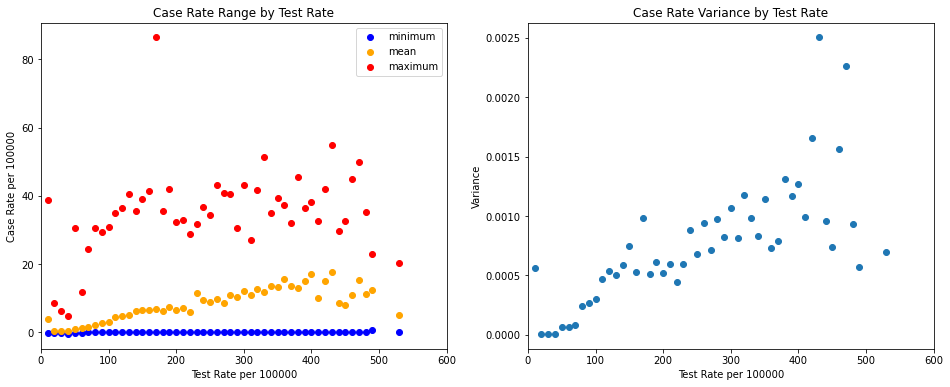

In [175]:
# Build a dataset with features test rate, case rate eliminating all invalid test rates (nan or ned)

cases_by_tests = np.transpose([tests[locations].values, cases[locations].values], axes=(1,2,0))
r, l, f = cases_by_tests.shape
cases_by_tests = cases_by_tests.reshape((r * l, f))

# cases_by_tests = cases_by_tests[~ (np.isnan(cases_by_tests[:,0]) | (cases_by_tests[:,0] < 0)), :]
cases_by_tests = cases_by_tests[(cases_by_tests[:,0] > 0), :]

# Group test rates into bins
test_bins = 10 * (((scale/10) * cases_by_tests[:,0]).astype("int32") + 1)
cases_by_test_bins = pd.DataFrame({"test_rate_interval": test_bins, "case_rate": cases_by_tests[:,1]})

# Build case_stats dataframe
group_stats = {
    "count": cases_by_test_bins.groupby("test_rate_interval").count(),
    "mean":  cases_by_test_bins.groupby("test_rate_interval").mean(),
    "var":   cases_by_test_bins.groupby("test_rate_interval").var(),
    "min":   cases_by_test_bins.groupby("test_rate_interval").min(),
    "max":   cases_by_test_bins.groupby("test_rate_interval").max()
}

case_stats_by_test_freq = pd.DataFrame(index=list(cases_by_test_bins.groupby("test_rate_interval").groups))

for var in group_stats:
#     print(type(group_stats[var]), len(group_stats[var]))
    case_stats_by_test_freq[var] = group_stats[var]
    
# print(len(case_stats_by_test_freq))
case_stats_by_test_freq = case_stats_by_test_freq[~ (case_stats_by_test_freq["count"] < 10)]
# print(len(case_stats_by_test_freq))

fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax2[0].scatter(case_stats_by_test_freq.index, scale * case_stats_by_test_freq["min"], c="blue", label="minimum")
ax2[0].scatter(case_stats_by_test_freq.index, scale * case_stats_by_test_freq["mean"], c="orange", label="mean")
ax2[0].scatter(case_stats_by_test_freq.index, scale * case_stats_by_test_freq["max"], c="red", label="maximum")
ax2[0].set_title("Case Rate Range by Test Rate")
ax2[0].set_ylabel(f"Case Rate per {scale}")
ax2[0].set_xlabel(f"Test Rate per {scale}")
ax2[0].set_xlim((0,600))
ax2[0].legend()
# plt.bar(100 * case_stats_by_test_freq.index, case_stats_by_test_freq["count"])

ax2[1].scatter(case_stats_by_test_freq.index, scale * case_stats_by_test_freq["var"])
ax2[1].set_title("Case Rate Variance by Test Rate")
ax2[1].set_ylabel(f"Variance")
ax2[1].set_xlabel(f"Test Rate per {scale}")
ax2[1].set_xlim((0,600))

# case_stats_by_test_freq

## Removing Trend from Case and Test Data by Subtraction

The following graphs show the case and test data with the 60-day moving average subtracted.  

The first thing to note is test data is substaially more noisy than case data.  This means that most of the variance in the positive test rate comes from testing.  

Let $\hat{c}_t$ represent the moiving average case rate and let $\hat{\tau}_t$ represent the moving average test rate.  Then the positive test rate, $\pi_t$, is given by 

$\pi = (\hat{c} + \epsilon_c) / (\hat{\tau} + \epsilon_\tau)$

Text(0.5, 1.0, 'Mean adjusted Tests vs Cases')

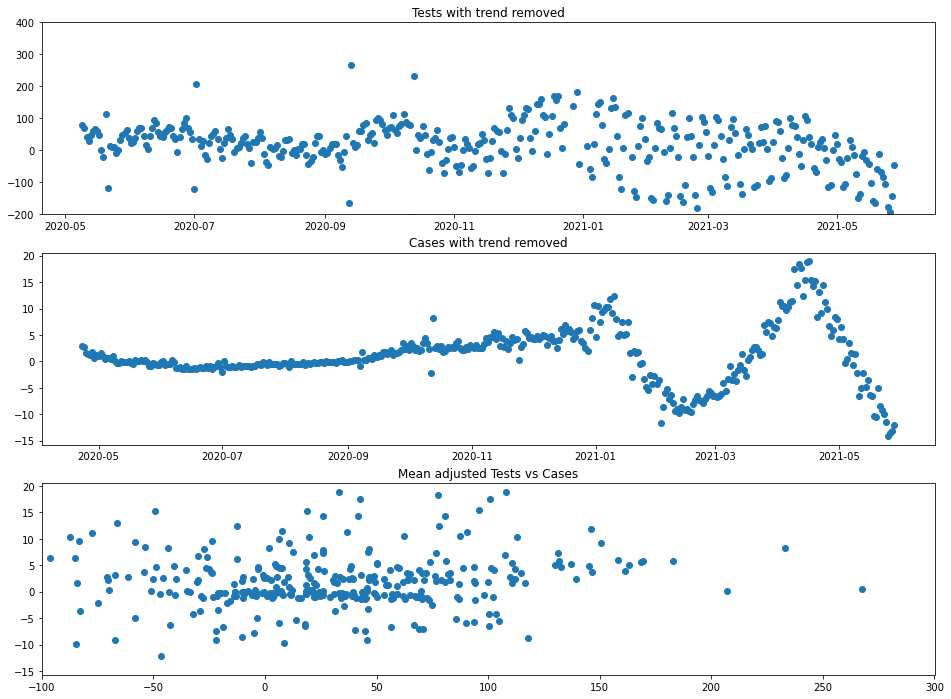

In [5]:
fig2, ax2 = plt.subplots(nrows=3, ncols=1, figsize=(16,12))

tests_mean_adj = tests - tests_ave
ax2[0].scatter(tests_mean_adj.index, tests_mean_adj[location])
ax2[0].set_ylim((-200,400))
ax2[0].set_title("Tests with trend removed")

cases_mean_adj = cases - cases_ave
ax2[1].scatter(cases_mean_adj.index, cases_mean_adj[location])
ax2[1].set_title("Cases with trend removed")

ax2[2].scatter(tests_mean_adj[90:][location], cases_mean_adj[90:][location])
ax2[2].set_xlim((-100,300))
ax2[2].set_title("Mean adjusted Tests vs Cases")

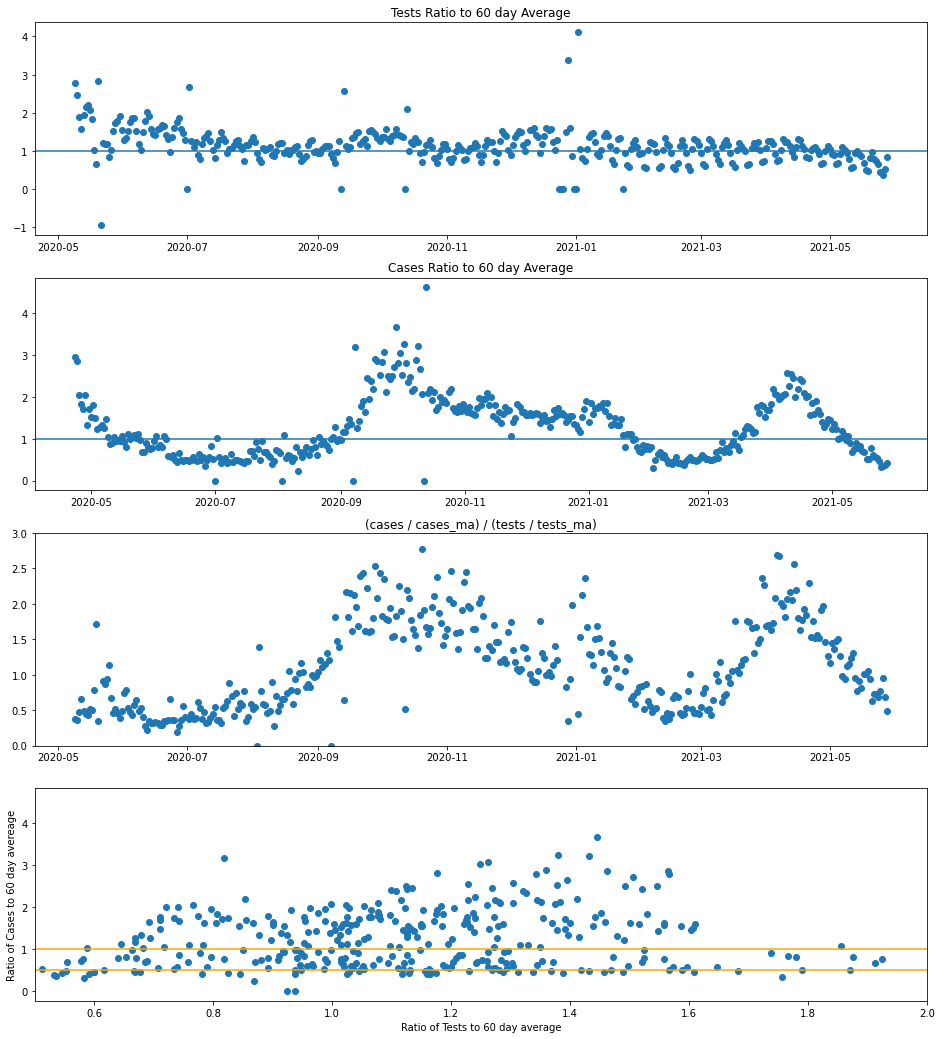

In [6]:
fig3, ax3 = plt.subplots(nrows=4, ncols=1, figsize=(16,18))

tests_ratio_to_mean = tests / tests_ave
ax3[0].scatter(tests_ratio_to_mean.index, tests_ratio_to_mean[location])
ax3[0].axhline(y=1)
# ax3[0].set_yscale=("log")
ax3[0].set_title("Tests Ratio to 60 day Average")

cases_ratio_to_mean = cases / cases_ave
ax3[1].scatter(cases_ratio_to_mean.index, cases_ratio_to_mean[location])
ax3[1].axhline(y=1)
# ax3[1].set_yscale=("log")
ax3[1].set_title("Cases Ratio to 60 day Average")

ax3[2].scatter(tests.index, cases_ratio_to_mean[location] / tests_ratio_to_mean[location])
ax3[2].set_ylim((0,3))
ax3[2].set_title("(cases / cases_ma) / (tests / tests_ma)")

ax3[3].scatter(tests_ratio_to_mean[90:][location], cases_ratio_to_mean[90:][location])
ax3[3].set_xlim((0.5,2))
ax3[3].set_ylabel("Ratio of Cases to 60 day avereage")
ax3[3].set_xlabel("Ratio of Tests to 60 day average")
ax3[3].axhline(y=0.5, c="orange")
ax3[3].axhline(y=1.0, c="orange")


No handles with labels found to put in legend.


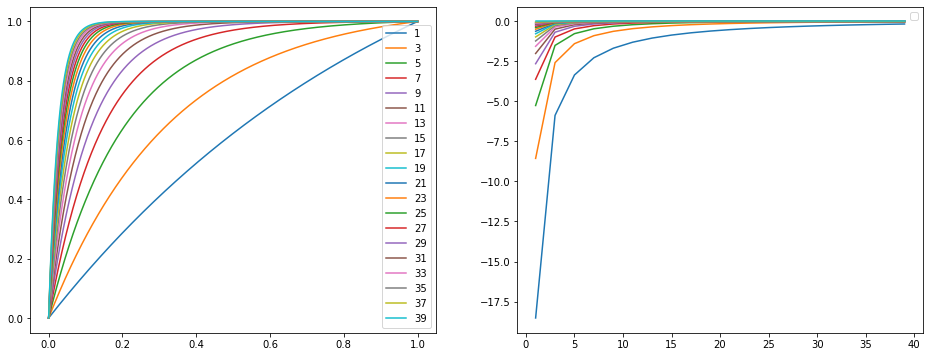

In [7]:
def g(x, theta):
    c = 1 / (np.exp(theta) - 1)
    return c * (np.exp(theta * x) - 1)

def f(x, theta):
    return 1 - g(1-x, theta)

def f_prime(x, theta):
    """differentiating wrt theta"""
    c = 1 / (np.exp(theta) - 1)
    return (c * (x-1) * np.exp(theta * (1-x))) / f(x, theta)

N = 1000
x = np.arange(N + 1) / N
thetas = 2 * np.arange(20) + 1

fig4, ax4 = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

for theta in thetas:
    ax4[0].plot(x, f(x, theta), label=f"{theta}")
ax4[0].legend()

for z in (np.arange(20) + 1) / 20:
    ax4[1].plot(thetas, f_prime(z, thetas))
ax4[1].legend()

460
(442, 2)
(442, 1)
[[0.9993886  0.03496322]]
442


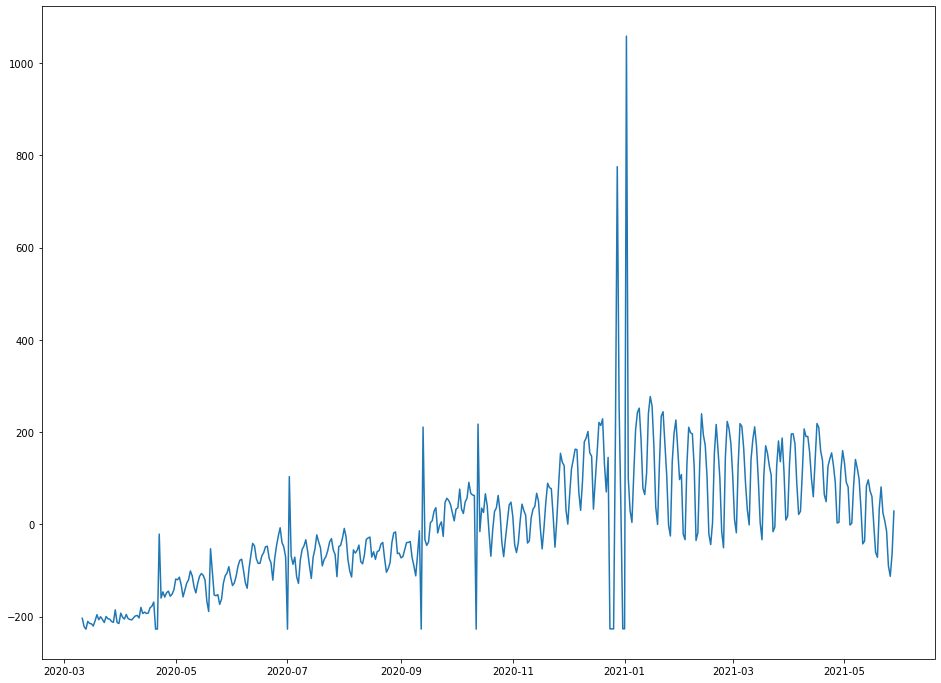

In [8]:
from sklearn.decomposition import PCA

valid_test_idx= tests[location]>0;
print(len(valid_test_idx))

ptrate = cases[location][valid_test_idx] / tests[location][valid_test_idx]

X = np.array([tests[location][valid_test_idx].values, cases[location][valid_test_idx].values]).T
print(X.shape)

pca = PCA(n_components=1)

Y = pca.fit_transform(X)
print(Y.shape)
      
print(pca.components_)

x_labels = tests[location][valid_test_idx].index
print(len(x_labels))

plt.figure(figsize=(16,12))
plt.plot(x_labels, Y.flatten())
# plt.plot(x_labels, Y.flatten() / tests[location].values, c="orange", lw=3)
